# Creating H5Types definitions

In [4]:
!python3 ../scripts/make_h5types.py -c ../config/Microcircuit.yaml --output-path datasets/MiV_h5types.h5

numprocs=1


In [6]:
!h5ls -r ./datasets/MiV_h5types.h5

/                        Group
/H5Types                 Group
/H5Types/Population\ labels Type
/H5Types/Population\ projections Type
/H5Types/Population\ range Type
/H5Types/Populations     Dataset {3}
/H5Types/Valid\ population\ projections Dataset {8}


In [9]:
!h5dump -d /H5Types/Populations ./datasets/MiV_h5types.h5

HDF5 "./datasets/MiV_h5types.h5" {
DATASET "/H5Types/Populations" {
   DATATYPE  H5T_COMPOUND {
      H5T_STD_U64LE "Start";
      H5T_STD_U32LE "Count";
      H5T_ENUM {
         H5T_STD_U16LE;
         "OLM"              102;
         "PVBC"             101;
         "PYR"              100;
      } "Population";
   }
   DATASPACE  SIMPLE { ( 3 ) / ( 3 ) }
   DATA {
   (0): {
         0,
         80000,
         PYR
      },
   (1): {
         80000,
         1474,
         PVBC
      },
   (2): {
         81474,
         438,
         OLM
      }
   }
}
}


# Copying and compiling NMODL mechanisms

In [1]:
!cp ../mechanisms/*.mod .

In [4]:
!~/bin/nrnpython3/bin/nrnivmodl .

/home/igr/src/model/MiV/notebooks
Mod files: "./ch_CavL.mod" "./ch_CavN.mod" "./ch_HCNolm.mod" "./ch_HCNp.mod" "./ch_KCaS.mod" "./ch_Kdrfast.mod" "./ch_Kdrp.mod" "./ch_KvAdistp.mod" "./ch_KvA.mod" "./ch_KvAolm.mod" "./ch_KvAproxp.mod" "./ch_KvCaB.mod" "./ch_leak.mod" "./ch_Navaxonp.mod" "./ch_Nav.mod" "./ch_Navp.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.cpp
 -> NMODL .././ch_CavL.mod
 -> NMODL .././ch_CavN.mod
 -> NMODL .././ch_HCNolm.mod
Translating ch_CavN.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_CavN.c
Notice: VERBATIM blocks are not thread safe
Translating ch_CavL.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_CavL.c
Notice: VERBATIM blocks are not thread safe
Translating ch_HCNolm.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_HCNolm.c
Notice: This mechanism cannot be used with CVODE
Notice: Assignment to the GLOBAL variable, "rexp", is not thread safe
Notice: Assignment to the GLOBAL variable, "rinf", is not thread safe

# Generating soma coordinates and measuring distances

In [6]:
!cp ../datasets/Microcircuit_coords.h5 datasets

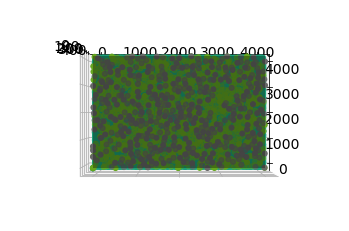

In [1]:
%run ../scripts/plot_coords_in_volume.py \
--config ../config/Microcircuit.yaml \
--coords-path datasets/Microcircuit_coords.h5 \
-i PYR -i PVBC -i OLM

# Distributing synapses along dendritic trees

In [1]:
!cp ../datasets/PYR_tree.h5 datasets/PYR_forest.h5

In [2]:
%run ../scripts/distribute_synapse_locs.py \
             --template-path ../templates \
             --config-prefix ../config \
              --config=Microcircuit.yaml \
              --populations PYR \
              --forest-path=./datasets/PYR_forest.h5 \
              --output-path=./datasets/PYR_forest.h5 \
              --distribution=poisson \
              --io-size=1 -v

INFO:MiV.distribute_synapse_locs.py:1 ranks have been allocated
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.distribute_synapse_locs.py:Rank 0 population: PYR
INFO:MiV.neuron_utils:Loaded PoolosPyramidalCell from ../templates/PoolosPyramidalCell.hoc
INFO:MiV.distribute_synapse_locs.py:Rank 0 gid: 0: {'x': array([ 0.      ,  0.      ,  0.      , ..., 47.959183, 48.97959 ,
       50.      ], dtype=float32), 'y': array([0.        , 0.25      , 0.5       , ..., 0.8926153 , 0.89261526,
       0.8926152 ], dtype=float32), 'z': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'radius': array([1.7, 1.7, 1.7, ..., 0.5, 0.5, 0.5], dtype=float32), 'layer': array([6, 6, 6, ..., 6, 6, 6], dtype=int8), 'parent': array([   -1,     0,     1, ..., 10342, 10343, 10344], dtype=int32), 'swc_type': array([1, 1, 1, ..., 7, 7, 7], dtype=int8), 'section': array([  0,   0,   0, ..., 201, 201, 201], dtype=uint16), 'section_topology': {'num_sections': 202, 'nodes': {0: 

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 1.00 s to compute 33932 synapse locations for PYR gid: 0
layer 8: excitatory synapses: 5414
layer 8: inhibitory synapses: 344
layer 9: excitatory synapses: 16646
layer 9: inhibitory synapses: 703
layer 5: excitatory synapses: 10260
layer 5: inhibitory synapses: 496
layer 6: excitatory synapses: 13
layer 6: inhibitory synapses: 56
swc_type 4: excitatory synapses: 22060
swc_type 4: inhibitory synapses: 863
swc_type 3: excitatory synapses: 10260
swc_type 3: inhibitory synapses: 496
swc_type 1: excitatory synapses: 13
swc_type 1: inhibitory synapses: 15
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 225
INFO:MiV.distribute_synapse_locs.py:Rank 0 gid is None
INFO:MiV.distribute_synapse_locs.py:Population: PYR, 1 ranks took 1.08 s to compute synapse locations for 1 cells
INFO:MiV.distribute_synapse_locs.py:PYR layer 8: mean excitatory synapses per cell: 5414.00
PYR layer 8: mean inhibitory synapses per cell: 344.00
PYR laye

# Generating connections

In [1]:
%run ../scripts/generate_distance_connections.py \
    --config-prefix=../config \
    --config=Microcircuit.yaml \
    --forest-path=datasets/PYR_forest.h5 \
    --connectivity-path=datasets/Microcircuit_connections.h5 \
    --connectivity-namespace=Connections \
    --coords-path=datasets/Microcircuit_coords.h5 \
    --coords-namespace='Generated Coordinates' \
    --io-size=1 --cache-size=20 --write-size=1 -v --dry-run

INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.generate_distance_connections.py:Reading OLM coordinates...
INFO:MiV.generate_distance_connections.py:Reading PVBC coordinates...
INFO:MiV.generate_distance_connections.py:Reading PYR coordinates...
INFO:MiV.generate_distance_connections.py:Generating connectivity for populations ['PYR']...
INFO:MiV.generate_distance_connections.py:Generating connection probabilities for population PYR...
INFO:MiV.connections:population PYR: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population PVBC: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population OLM: layer: default: 
u width: 420.0
v width: 250.0
u scale_factor: 140.0
v scale_factor: 83.33333333333333

INFO:MiV.generate_distance_connections.py:Generating connections for pop